%%capture
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

In [1]:
import os
import sys

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import spearmanr

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
# import pertpy as pt
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.util_plot as nmd_plot
from tools import NMD as nmd

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import kendalltau
import importlib

In [2]:
def plot_reconstruction(
    X_reconstruction, X, title,hue=None, type="scatter", sample_fraction=None
):
    """Plot original sparse non-negative matrix against the reconstructed one

    Also computes the Pearson correlation between both

    Args:
        X_reconstruction (_type_): Reconstructed matrix, e.g. np.maximum(0, Theta)
        X (_type_): The original sparse non-negative matrix
        title (_type_): _description_
        type (str, optional): _description_. Defaults to "scatter".
        sample_fraction (_type_, optional): _description_. Defaults to None.
    """
    X_recon_max = np.max(X_reconstruction)
    X_max = np.max(X)
    max_axis = max(X_recon_max, X_max)
    correlation = np.corrcoef(X_reconstruction.flatten(), X.flatten())[0][1]

    df = pd.DataFrame(
        {"original": X.flatten(), "reconstruction": X_reconstruction.flatten()}
    )

    if sample_fraction:
        df = df.sample(frac=sample_fraction, axis=0)

    fig, ax = plt.subplots()
    match type:
        case "scatter":
            if hue is not None:
                p = sns.scatterplot(data=df, x="reconstruction", y="original", hue=hue, alpha=0.1)
            else:
                p = sns.scatterplot(data=df, x="reconstruction", y="original", alpha=0.1)
        # case "kde":
        # p = sns.kdeplot(X_reconstruction.flatten(), X.flatten())
        # p = sns.kdeplot(data=df, x="reconstruction", y="original")
    p.set_ylim(0, max_axis)
    p.set_xlim(0, max_axis)
    plt.suptitle(title)
    plt.title(f"Pearson correlation: {round(correlation, 3)}")
    plt.xlabel("Reconstruction")
    plt.ylabel("Original data")
    ax.axline(xy1=(0, 0), slope=1, linewidth=1, color="r")
    plt.show()


In [3]:
data_all_pca = sc.read_h5ad("../../data/MOBA_scRNAseq/MOBA_intermediate_results/export_s3.h5ad")
data_all_pca

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'total_counts', 'n_genes_by_counts', 'leiden_opt'
    var: 'total_counts', 'n_cells_by_counts', 'TU_ID', 'nb_overdisp_cutoff', 'pval_cluster_0', 'pval_cluster_1', 'pval_cluster_2', 'pval_cluster_3'
    uns: 'leiden', 'leiden_opt_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
data_all_pca.varm["PCs"].shape

(5553, 50)

In [5]:
data_counts = sc.read_h5ad("../../data/MOBA_scRNAseq/MOBA_intermediate_results/S3_filtered_with_counts.h5ad")
data_counts

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'

In [6]:
importlib.reload(nmd_plot)

<module 'tools.util_plot' from '/dss/dsshome1/07/di35buw/NMD/BacSC/tools/util_plot.py'>

In [7]:
data_all_pca.uns["leiden_opt_colors"]

array(['#1f77b4', '#d62728', '#e377c2', '#17becf'], dtype=object)

In [8]:
data_counts.X = data_counts.layers["counts"].copy()

In [9]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_counts, target_sum=None, layer=None)

# Only normalization
data_counts.layers["normalized_counts"] = data_counts.X.copy()


### Search latent dimensions

In [10]:
data_train, data_test = cs.countsplit_adata(data_counts, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="normalized_counts", min_genes=1, max_counts=1e9, seed=1234)

In [11]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_train, target_sum=None, layer=None)

# Only normalization
data_train.layers["normalized_counts"] = data_train.X.copy()

# Variance Stabilization Transformation
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
data_train.layers["vst_counts_shifted"] = data_train.layers["vst_counts"].copy().todense() + data_train.layers["vst_counts"].min() * -1.

# test data
sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.layers["normalized_counts"] = data_test.X.copy()
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
data_test.layers["vst_counts_shifted"] = data_test.layers["vst_counts"].copy().todense() + data_test.layers["vst_counts"].min() * -1.

In [12]:
importlib.reload(cs)

<module 'tools.countsplit' from '/dss/dsshome1/07/di35buw/NMD/BacSC/tools/countsplit.py'>

In [13]:
data_layer = "normalized_counts"

In [14]:
ks_2_check = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
betas_2_check = [0.4, 0.5, 0.6, 0.7, 0.8]
tol_over_10iters = 1e-3

In [15]:
select_cs_results = cs.select_3b_params_countsplit(data_train, data_test, potential_ks=ks_2_check, potential_betas=betas_2_check, layer=data_layer, tol_over_10iters=tol_over_10iters)

################## LATENT DIM 10
################## BETA 0.4
################## BETA 0.5
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 9
################## BETA 0.4
################## BETA 0.5
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 8
################## BETA 0.4
################## BETA 0.5
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 7
################## BETA 0.4
################## BETA 0.5
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 6
################## BETA 0.4
################## BETA 0.5
################## BETA 0.6
################## BETA 0.7
################## BETA 0.8
################## LATENT DIM 5
################## BETA 0.4
################## BETA 0.5
################## BETA 0.6
################## BETA

<Axes: xlabel='k', ylabel='loss'>

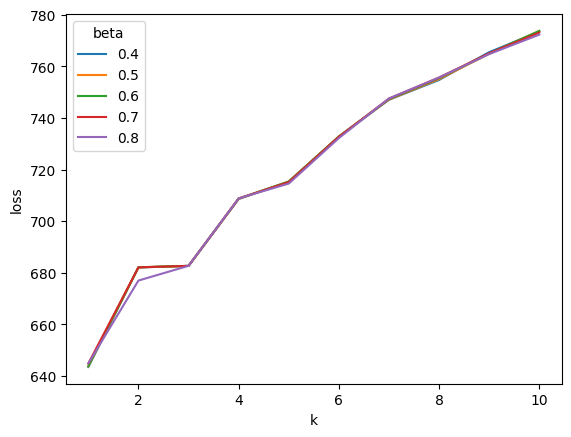

In [19]:
sns.lineplot(data=select_cs_results, x="k", y="loss", hue="beta", palette="tab10")

In [23]:
k_opt, beta_opt, _ = select_cs_results.sort_values(by="loss").iloc[0]

In [21]:
print(f"Optimal latent dim: {k_opt}")
print(f"Optimal beta: {beta_opt}")

Optimal latent dim: 1.0
Optimal beta: 0.4


## Fit NMD

In [25]:
k_opt = int(k_opt)

In [26]:
k_opt = 2

##### Nuclear norm

In [27]:
m, n = data_counts.X.shape
X_nmd = ut.convert_to_dense_counts(data_counts, layer=data_layer)
m, n = X_nmd.shape
W0, H0 = cs.nuclear_norm_init(X_nmd, m, n, k_opt)
Theta0 = W0 @ H0

In [28]:
Theta_3b, W_3b, H_3b, loss_3b, iters_3b, times_3b = nmd.nmd_3b(X_nmd, r=k_opt, W0=W0, H0=H0, beta1=beta_opt, tol_over_10iters=1e-4)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 68.956017] - 0.633756 secs
[1 : 68.105124] - 0.642294 secs
[2 : 67.538225] - 0.686364 secs
[3 : 67.316624] - 0.639714 secs
[4 : 67.216164] - 0.642845 secs
[5 : 67.164610] - 0.654903 secs
[6 : 67.133102] - 0.669082 secs
[7 : 67.110522] - 0.646716 secs
[8 : 67.093939] - 0.650903 secs
[9 : 67.081692] - 0.658178 secs
[10 : 67.071890] - 0.664375 secs
[11 : 67.063760] - 0.645734 secs
[12 : 67.056879] - 0.638636 secs
[13 : 67.050881] - 0.654026 secs
[14 : 67.045582] - 0.666943 secs
[15 : 67.040884] - 0.645414 secs
[16 : 67.036616] - 0.638460 secs
[17 : 67.032657] - 0.653765 secs
[18 : 67.028908] - 0.663438 secs
[19 : 67.025309] - 0.643015 secs
[20 : 67.021807] - 0.653722 secs
[21 : 67.018372] - 0.657342 secs
[22 : 67.014967] - 0.673020 secs
[23 : 67.011600] - 0.644254 secs
[24 : 67.008229] - 0.647666 secs
[25 : 67.004845] - 0.643104 secs
[26 : 67.001419] - 0.663262 secs
[27 : 66.997940] - 0.645410 

In [32]:
importlib.reload(nmd_plot)

<module 'tools.util_plot' from '/dss/dsshome1/07/di35buw/NMD/BacSC/tools/util_plot.py'>

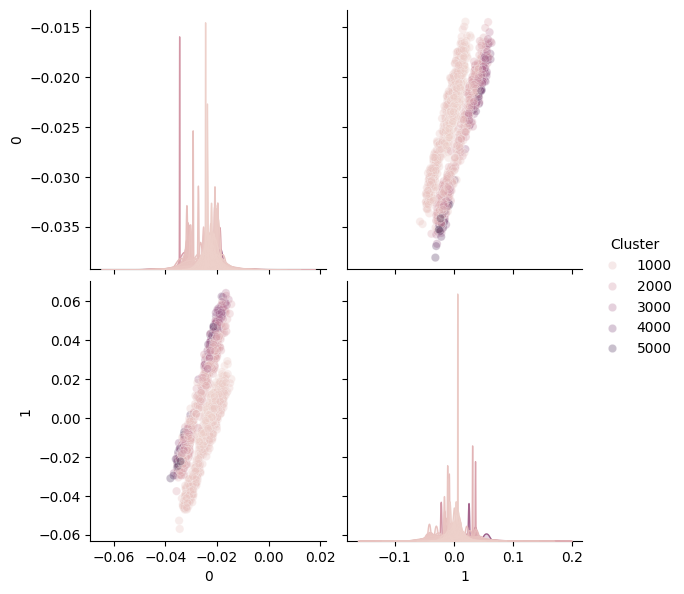

In [33]:
nmd_plot.plot_embedding_grid(W0, hue=data_counts.obs["total_counts"], size=3)

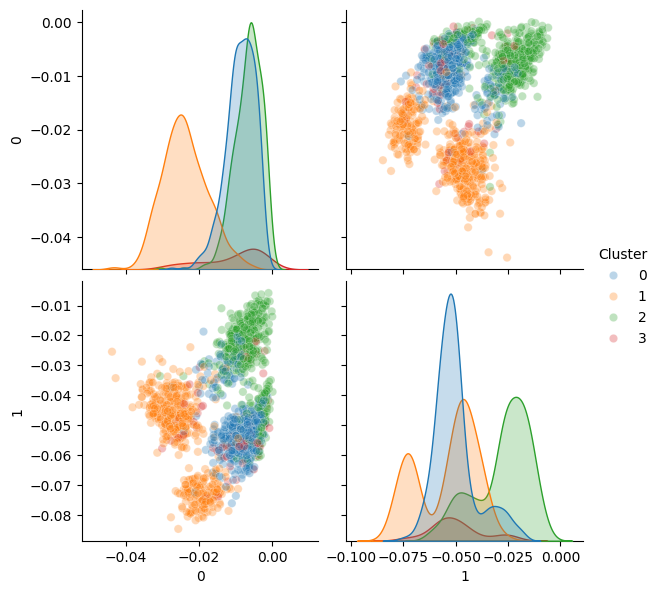

In [34]:
nmd_plot.plot_embedding_grid(W_3b, hue=data_all_pca.obs["leiden_opt"], size=3)

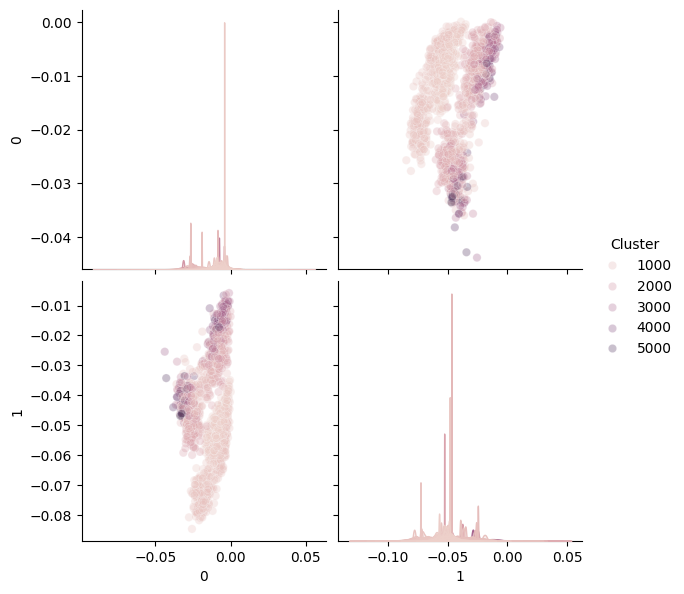

In [35]:
nmd_plot.plot_embedding_grid(W_3b, data_counts.obs["total_counts"], size=3)

##### Row-wise mean init

In [36]:
def factor_theta(theta, rank):
    ua, sa, va = np.linalg.svd(theta, full_matrices=False)
    sa = np.diag(sa)[:rank, :rank]
    W0 = ua[:, :rank]
    H0 = sa @ va[:rank, :]
    return W0, H0

In [37]:
shape = X_nmd.shape
row_means = np.mean(X_nmd, axis=1)
Theta0_rowmeans = np.repeat(row_means, shape[1]).reshape(shape)

In [38]:
W0_rm, H0_rm = factor_theta(Theta0_rowmeans, rank=k_opt)

In [39]:
Theta_3b_rm, W_3b_rm, H_3b_rm, loss_3b_rm, iters_3b_rm, times_3b_rm = nmd.nmd_3b(X_nmd, r=k_opt, W0=W0_rm, H0=H0_rm, beta1=beta_opt, tol_over_10iters=1e-4)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 74.932553] - 0.675356 secs
[1 : 67.461066] - 0.661641 secs
[2 : 66.747446] - 0.659910 secs
[3 : 66.696900] - 0.675668 secs
[4 : 66.691378] - 0.700973 secs
[5 : 66.690022] - 0.667335 secs
[6 : 66.689484] - 0.660453 secs
[7 : 66.689040] - 0.676902 secs
[8 : 66.688655] - 0.673420 secs
[9 : 66.688330] - 0.659467 secs
[10 : 66.688047] - 0.664190 secs
[11 : 66.687795] - 0.674065 secs
[12 : 66.687561] - 0.676168 secs

Converged: abs(rel. err.(i) - rel. err.(i-10)) < 0.0001

Final relative error: 66.68733803698397%, after 14 iterations.
Initialization time: 0.436915 secs
Mean time per iteration: 0.658052 secs
Total time: 9.649638 secs



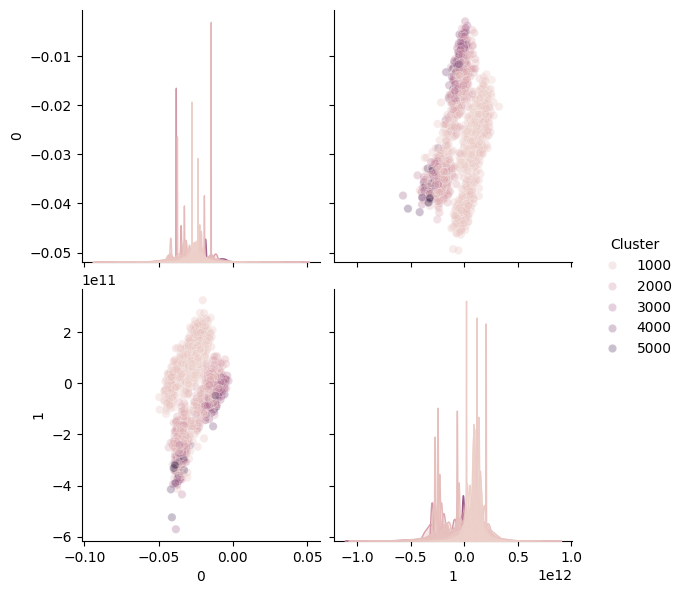

In [40]:
nmd_plot.plot_embedding_grid(W_3b_rm, hue=data_counts.obs["total_counts"], size=3)

In [41]:
data_counts.obsm["X_3b"] = W_3b.copy()

In [42]:
importlib.reload(scd)

n_neighborss = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(
    data_counts, n_neighborss, min_dists, n_pcs=k_opt, rng_seed=5678, layer = data_layer,
    dim_red_method="3B-NMD", dim_red_params={"beta1": beta_opt, "tol_over_10iters": tol_over_10iters},
    embedding_method="UMAP", similarity_percent=0.5, save_path="S2_filtered_scdeed_nmd")

calculating (10, 0.05) - run 1/85


2024-03-16 21:39:45.612602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 21:39:45.612738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 21:39:45.618073: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-16 21:39:45.639133: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 0.7) - run 30/85
calculating (40, 

Optimal number of neighbors: 50
Optimal min_dist: 0.7


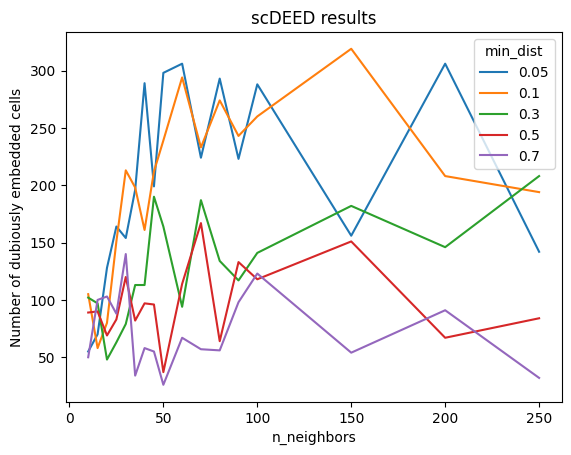

In [43]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [44]:
sc.pp.neighbors(data_counts, n_neighbors=n_neighbors_opt, n_pcs=k_opt, use_rep="X_3b")
sc.tl.umap(data_counts, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)

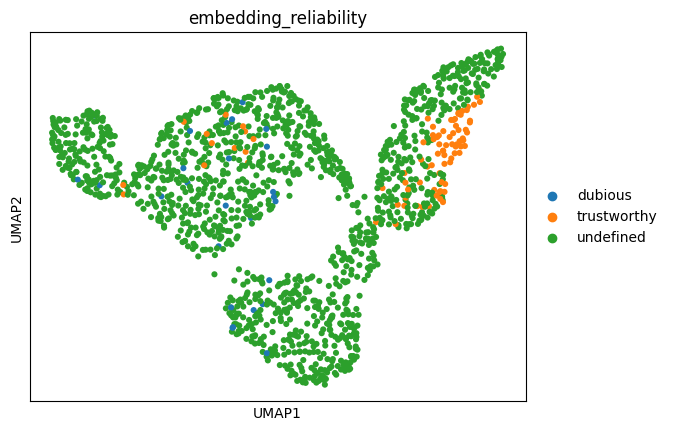

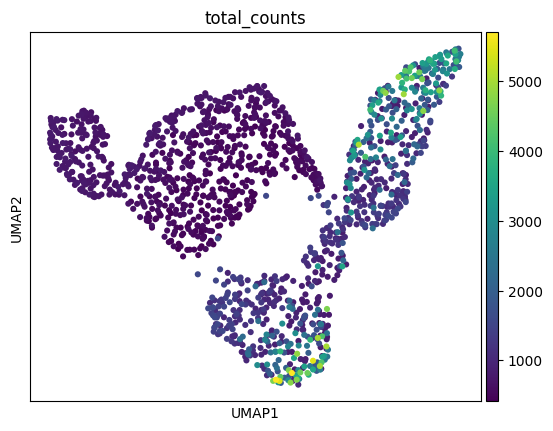

In [45]:
sc.pl.umap(data_counts, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(data_counts, color="total_counts", alpha=1, cmap="viridis")
plt.show()

In [46]:
data_train, data_test = cs.countsplit_adata(data_counts, data_dist="NB", beta_key="nb_overdisp_cutoff", layer=data_layer, min_genes=1, max_counts=1e9, seed=1234)

In [47]:
# Normalizes X, such that: each barcode has total count equal to median of total counts before normalization
sc.pp.normalize_total(data_train, target_sum=None, layer=None)

# Only normalization
data_train.layers["normalized_counts"] = data_train.X.copy()

# Variance Stabilization Transformation
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
data_train.layers["vst_counts_shifted"] = data_train.layers["vst_counts"].copy().todense() + data_train.layers["vst_counts"].min() * -1.

# test data
sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.layers["normalized_counts"] = data_test.X.copy()
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
data_test.layers["vst_counts_shifted"] = data_test.layers["vst_counts"].copy().todense() + data_test.layers["vst_counts"].min() * -1.

In [48]:
k_opt = 2

In [49]:
X_train = ut.convert_to_dense_counts(data_train, layer=data_layer)
m, n = X_train.shape
W0_train, H0_train = cs.nuclear_norm_init(X_train, m, n, k_opt)

In [50]:
X_test = ut.convert_to_dense_counts(data_test, layer=data_layer)
m, n = X_test.shape
W0_test, H0_test = cs.nuclear_norm_init(X_test, m, n, k_opt)

In [51]:
_, W_train, H_train,  _, _, _ = nmd.nmd_3b(X_train, r=k_opt, W0=W0_train, H0=H0_train, beta1=beta_opt, tol_over_10iters=tol_over_10iters)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 76.967320] - 0.576078 secs
[1 : 76.784799] - 0.584512 secs
[2 : 76.670756] - 0.605085 secs
[3 : 76.582776] - 0.601733 secs
[4 : 76.513188] - 0.579761 secs
[5 : 76.446762] - 0.586925 secs
[6 : 76.376490] - 0.600319 secs
[7 : 76.299487] - 0.595690 secs
[8 : 76.214778] - 0.585883 secs
[9 : 76.120830] - 0.584475 secs
[10 : 76.016249] - 0.618659 secs
[11 : 75.899923] - 0.602613 secs
[12 : 75.771561] - 0.579983 secs
[13 : 75.631242] - 0.583217 secs
[14 : 75.480645] - 0.606472 secs
[15 : 75.322642] - 0.604678 secs
[16 : 75.160013] - 0.582203 secs
[17 : 74.996692] - 0.585597 secs
[18 : 74.836642] - 0.607941 secs
[19 : 74.683072] - 0.600973 secs
[20 : 74.539177] - 0.587258 secs
[21 : 74.407209] - 0.589963 secs
[22 : 74.288429] - 0.606138 secs
[23 : 74.183541] - 0.637292 secs
[24 : 74.092212] - 0.591416 secs
[25 : 74.013960] - 0.584429 secs
[26 : 73.947407] - 0.605341 secs
[27 : 73.891068] - 0.611568 

In [52]:
_, W_test, H_test,  _, _, _ = nmd.nmd_3b(X_test, r=k_opt, W0=W0_test, H0=H0_test, beta1=beta_opt, tol_over_10iters=tol_over_10iters)

Running 3B-NMD, evolution of [iteration number : relative error in %] - time per iteration
[0 : 77.595120] - 0.579603 secs
[1 : 77.424358] - 0.609550 secs
[2 : 77.330013] - 0.600978 secs
[3 : 77.269992] - 0.593275 secs
[4 : 77.230895] - 0.583007 secs
[5 : 77.199071] - 0.635905 secs
[6 : 77.172440] - 0.598788 secs
[7 : 77.148643] - 0.611983 secs
[8 : 77.127479] - 0.613661 secs
[9 : 77.106708] - 0.634525 secs
[10 : 77.085739] - 0.616601 secs
[11 : 77.062850] - 0.715077 secs
[12 : 77.038292] - 0.600573 secs
[13 : 77.010716] - 0.611334 secs
[14 : 76.979744] - 0.602480 secs
[15 : 76.944538] - 0.596412 secs
[16 : 76.903815] - 0.580229 secs
[17 : 76.856842] - 0.611655 secs
[18 : 76.803014] - 0.598380 secs
[19 : 76.742088] - 0.590346 secs
[20 : 76.673607] - 0.588002 secs
[21 : 76.597420] - 0.605545 secs
[22 : 76.513883] - 0.590941 secs
[23 : 76.422956] - 0.585878 secs
[24 : 76.324873] - 0.582651 secs
[25 : 76.220361] - 0.608067 secs
[26 : 76.110337] - 0.599428 secs
[27 : 75.995854] - 0.596311 

In [53]:
data_train.obsm["X_3b"] = W_train
data_test.obsm["X_3b"] = W_test

In [54]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt, use_rep="X_3b")
sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt, use_rep="X_3b")

In [55]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

In [56]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.459 - Test: 0.378 - Random: 0.227
resolution: 0.07 - clusters: 4 - Train: 0.447 - Test: 0.242 - Random: 0.14
resolution: 0.09 - clusters: 3 - Train: 0.438 - Test: 0.322 - Random: 0.177
resolution: 0.11 - clusters: 4 - Train: 0.435 - Test: 0.231 - Random: 0.123
resolution: 0.13 - clusters: 5 - Train: 0.428 - Test: 0.196 - Random: 0.089
resolution: 0.15 - clusters: 5 - Train: 0.425 - Test: 0.188 - Random: 0.087
resolution: 0.17 - clusters: 6 - Train: 0.411 - Test: 0.148 - Random: 0.068
resolution: 0.19 - clusters: 5 - Train: 0.413 - Test: 0.165 - Random: 0.07
resolution: 0.21 - clusters: 6 - Train: 0.408 - Test: 0.142 - Random: 0.057
resolution: 0.23 - clusters: 6 - Train: 0.407 - Test: 0.153 - Random: 0.055
resolution: 0.25 - clusters: 7 - Train: 0.402 - Test: 0.116 - Random: 0.038
resolution: 0.27 - c

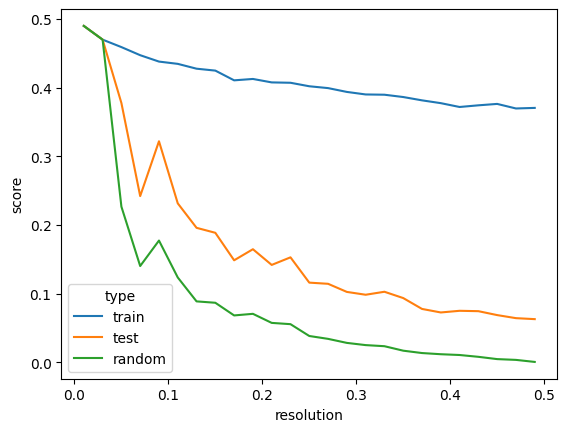

In [57]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.show()

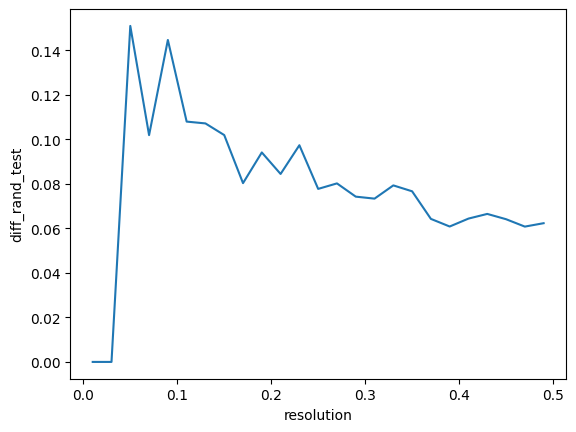

In [58]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.show()

In [59]:
sc.tl.leiden(data_counts, resolution=res_opt, key_added="leiden_opt")

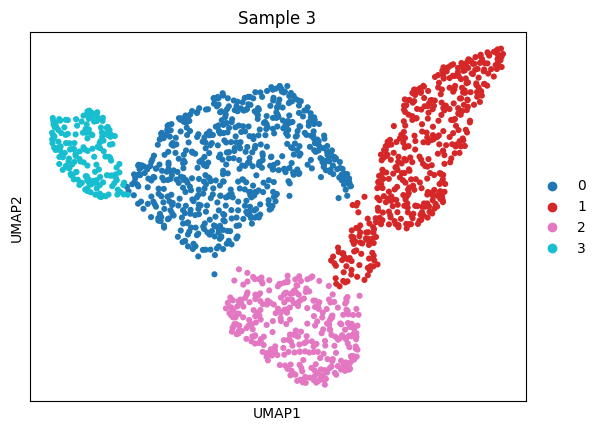

In [60]:
sc.pl.umap(data_counts, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

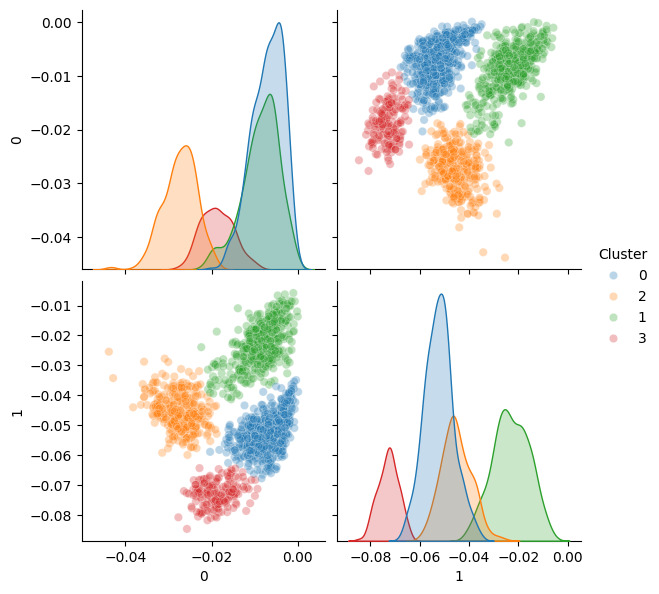

In [61]:
nmd_plot.plot_embedding_grid(data_counts.obsm["X_3b"], hue=data_counts.obs["leiden_opt"], size=3)


In [62]:
pd.crosstab(data_all_pca.obs["leiden_opt"], data_counts.obs["leiden_opt"], rownames=['PCA'], colnames=['NMD'])

NMD    0    1    2    3
PCA                    
0    432   73    3    9
1     21   12  295  154
2    114  355    2    0
3     42   12   15    5

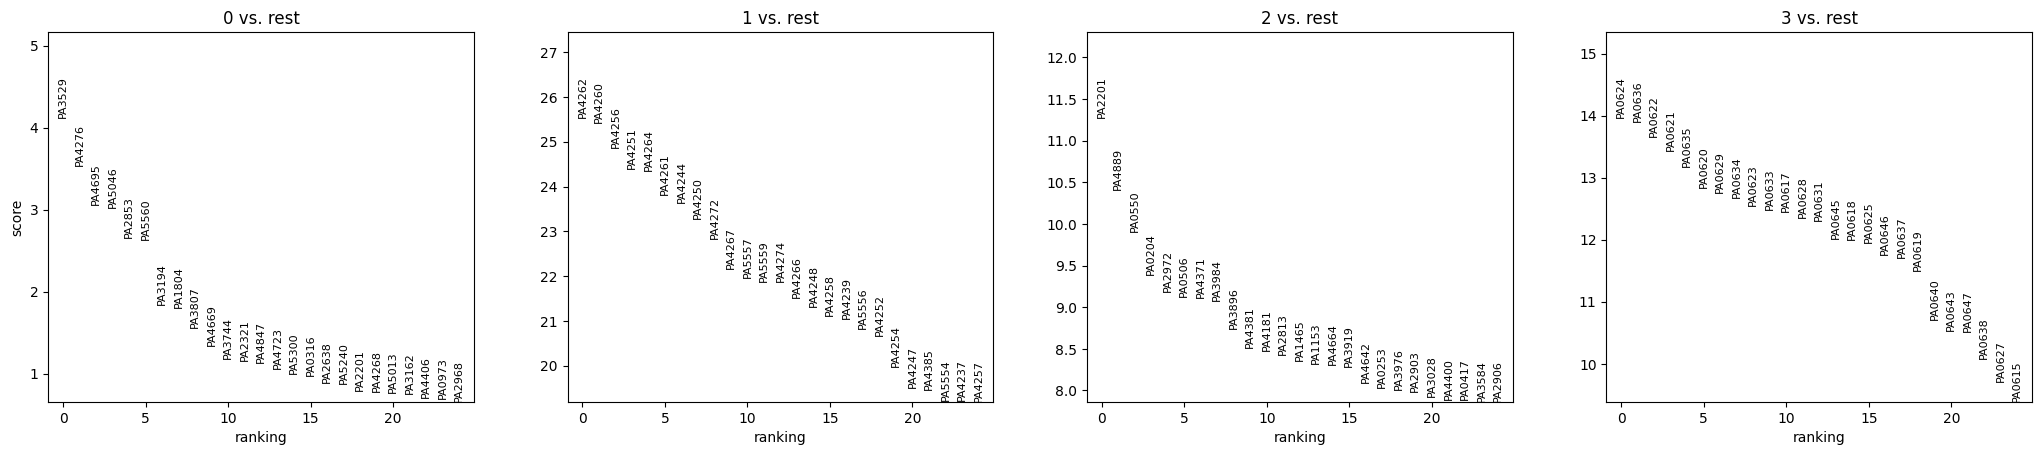

In [63]:
sc.tl.rank_genes_groups(data_all_pca, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_all_pca, n_genes=25, sharey=False)

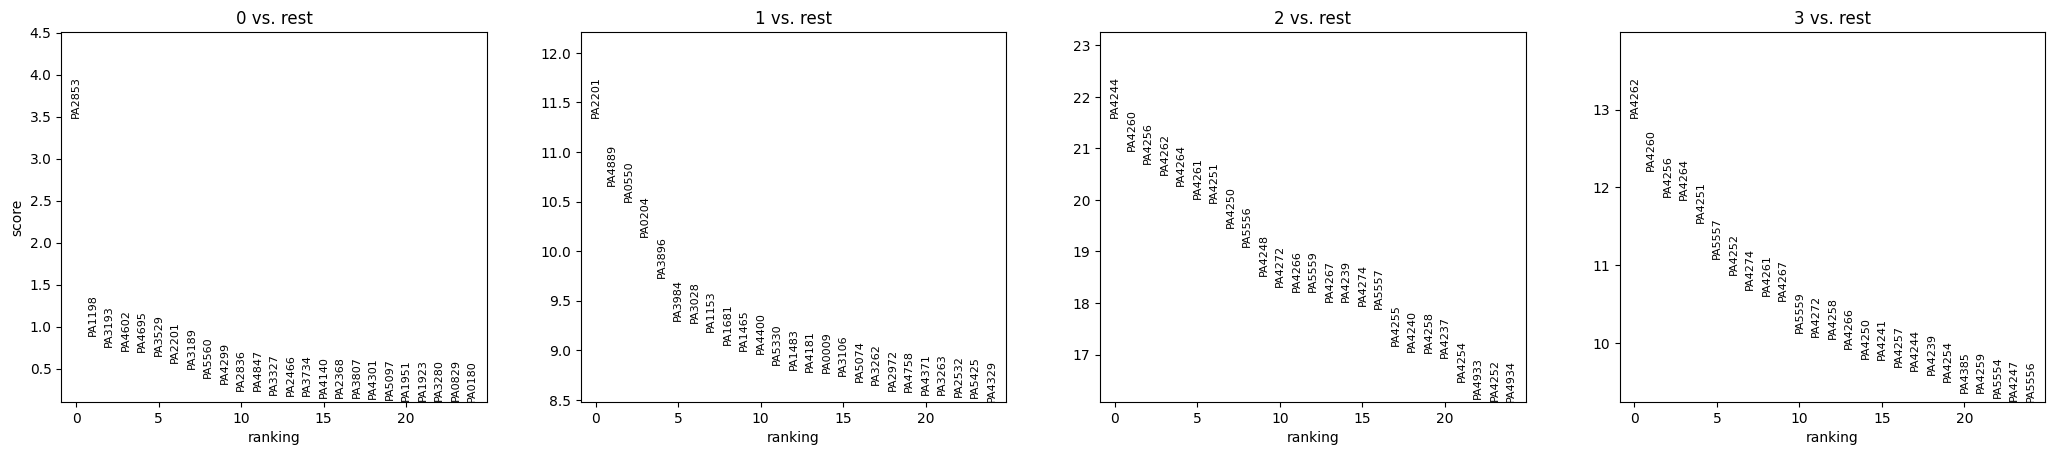

In [64]:
sc.tl.rank_genes_groups(data_counts, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_counts, n_genes=25, sharey=False)

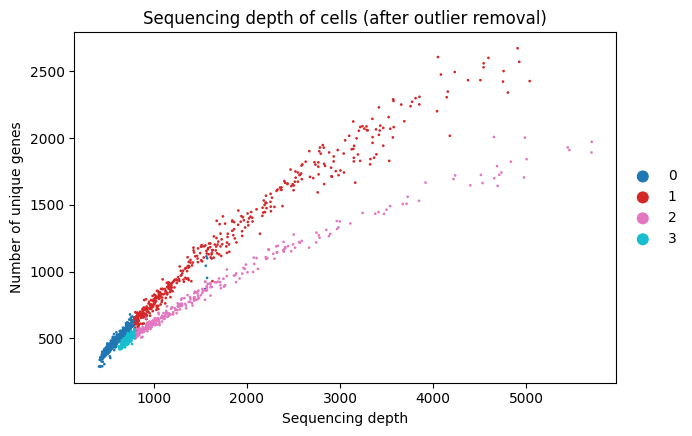

In [65]:
sc.pl.scatter(data_counts, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

In [66]:
top_genes_3 = [x[2] for x in data_counts.uns["rank_genes_groups"]["names"]]
print(top_genes_3[:25])

['PA4244', 'PA4260', 'PA4256', 'PA4262', 'PA4264', 'PA4261', 'PA4251', 'PA4250', 'PA5556', 'PA4248', 'PA4272', 'PA4266', 'PA5559', 'PA4267', 'PA4239', 'PA4274', 'PA5557', 'PA4255', 'PA4240', 'PA4258', 'PA4237', 'PA4254', 'PA4933', 'PA4252', 'PA4934']


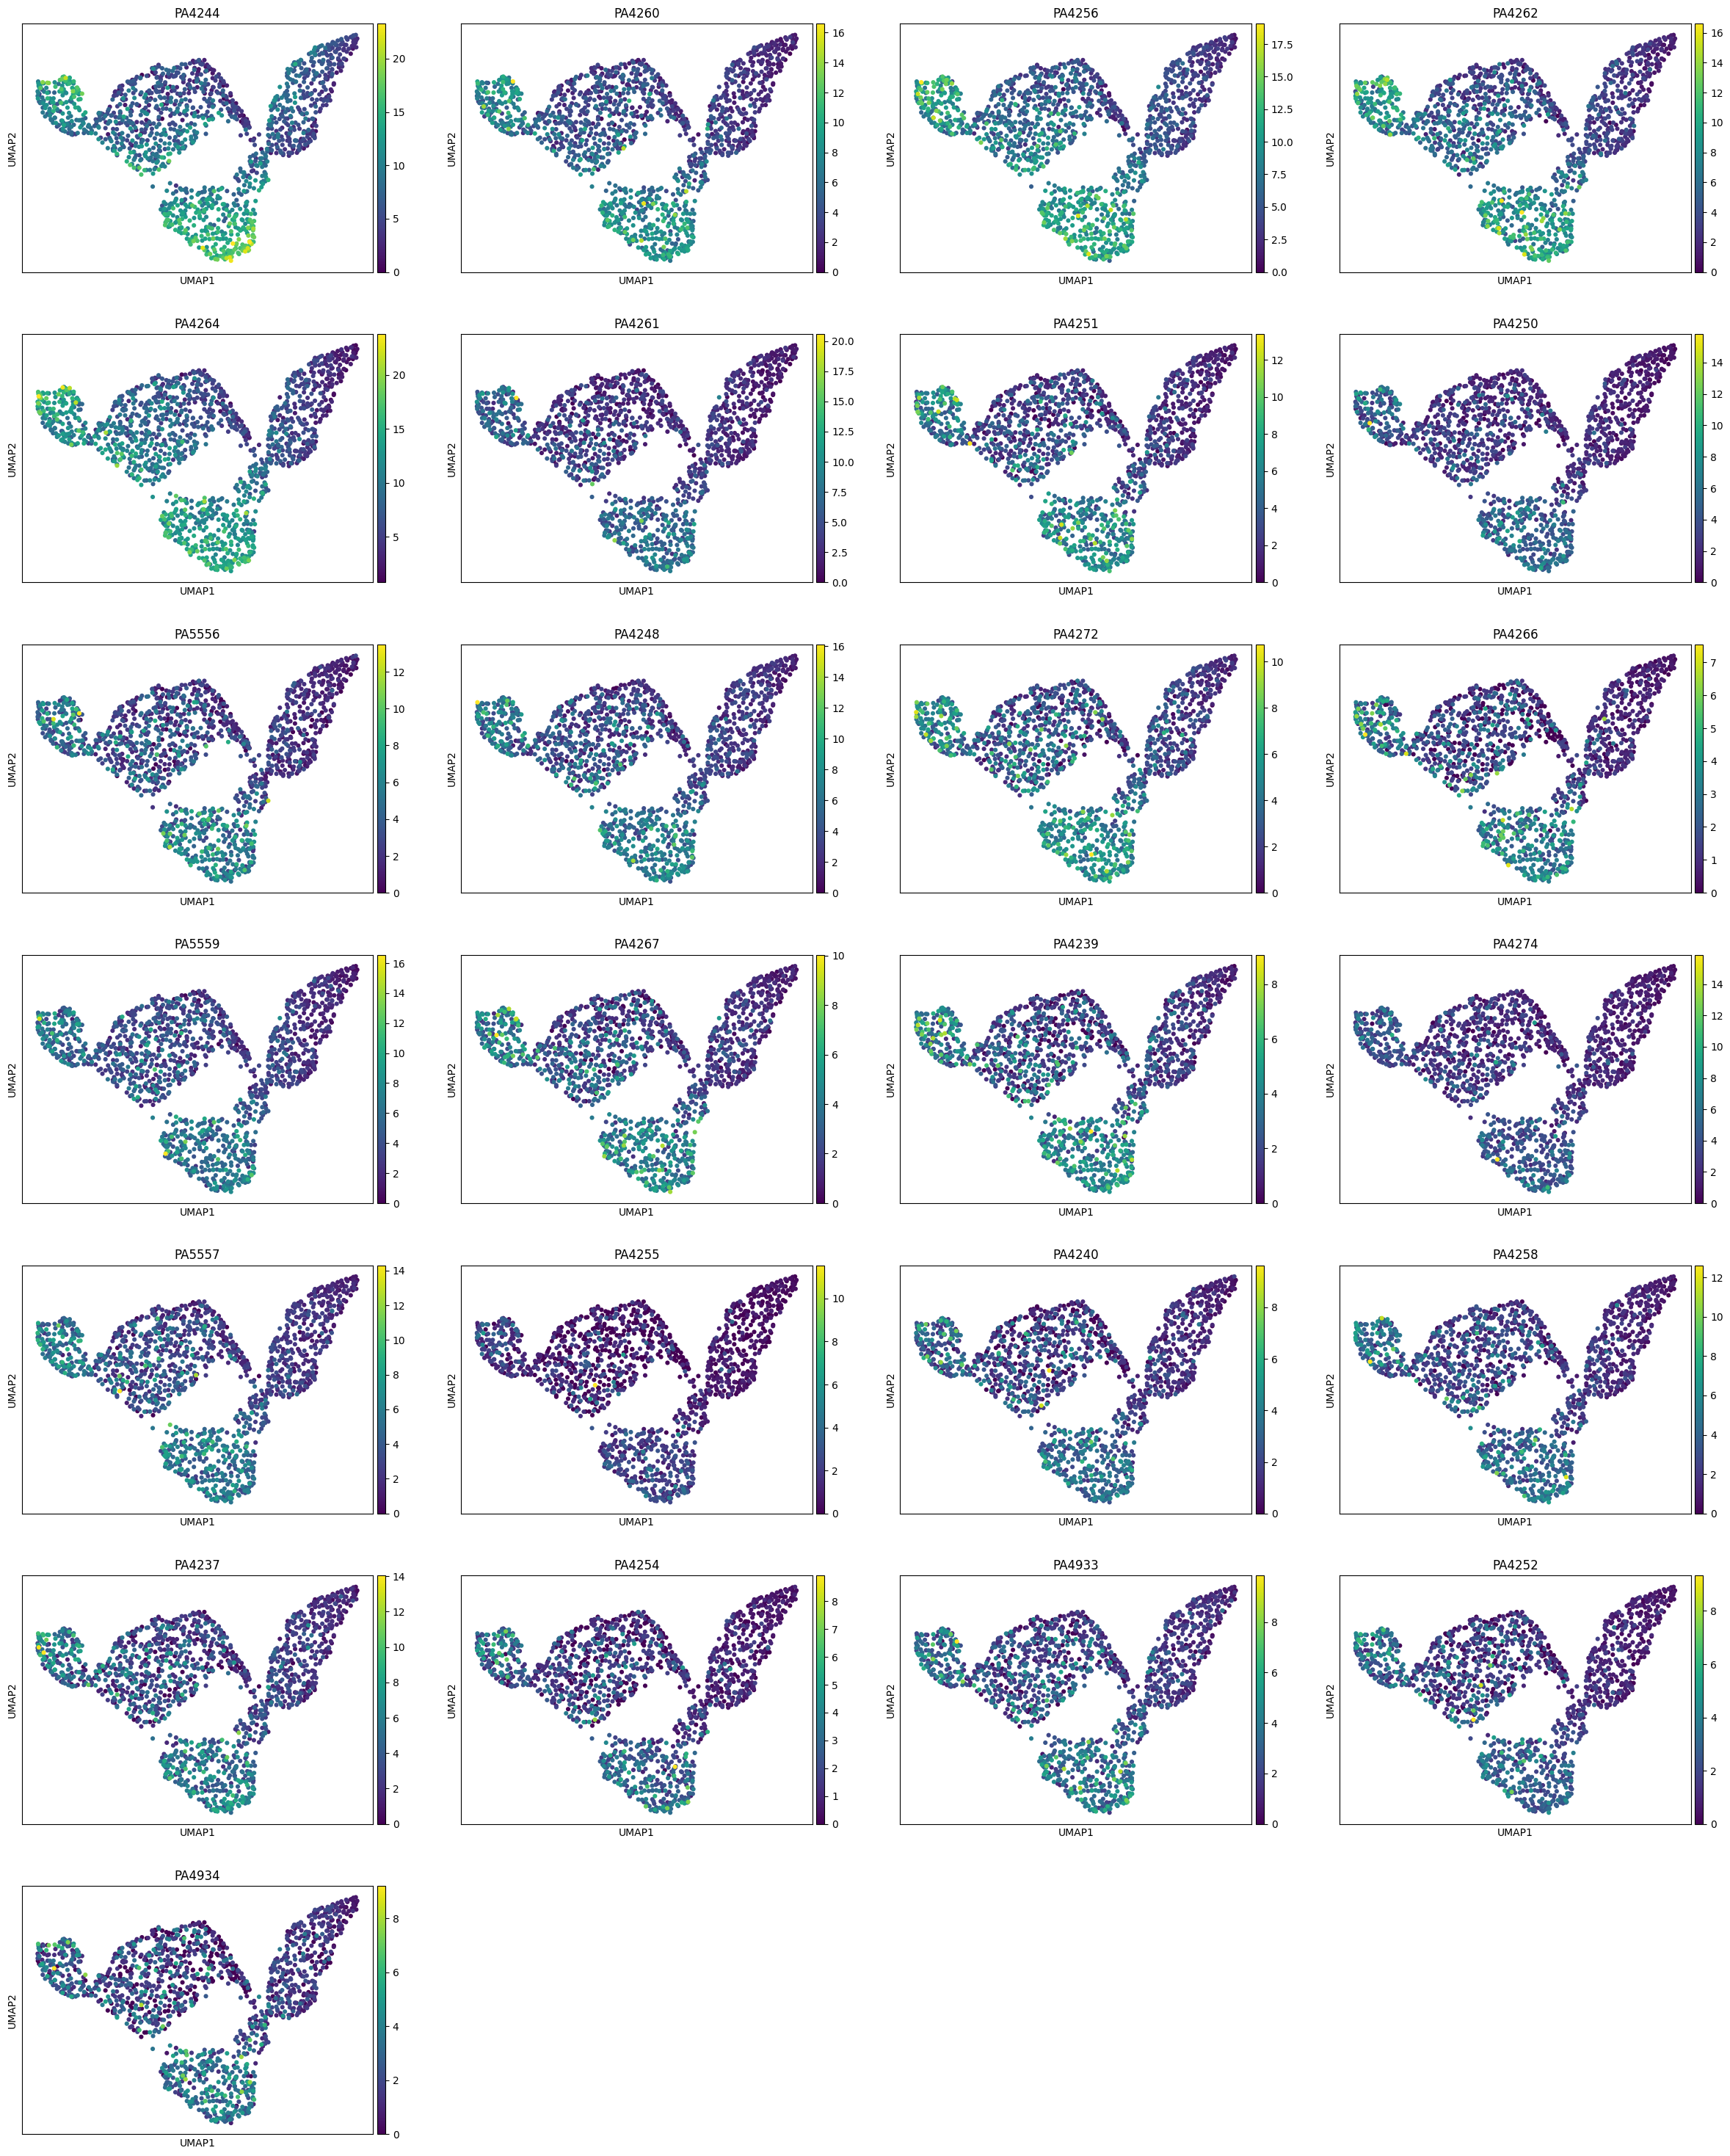

In [67]:
sc.pl.umap(data_counts, color=top_genes_3[:25], palette="tab20", cmap="viridis")

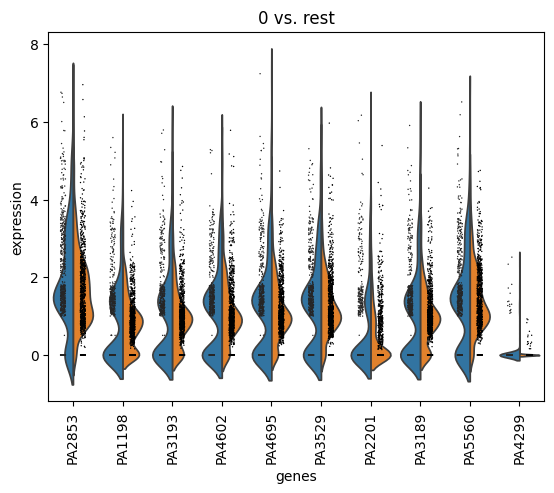

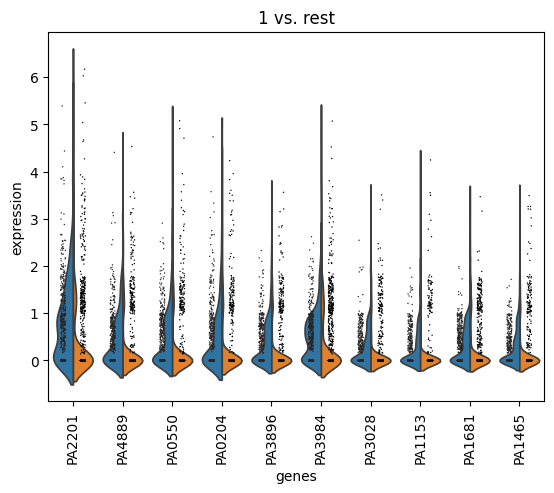

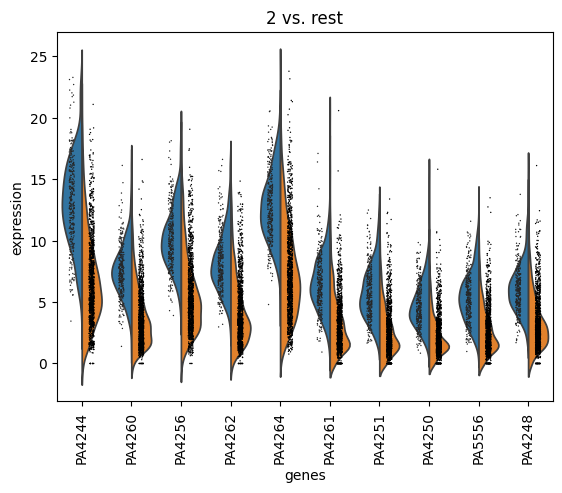

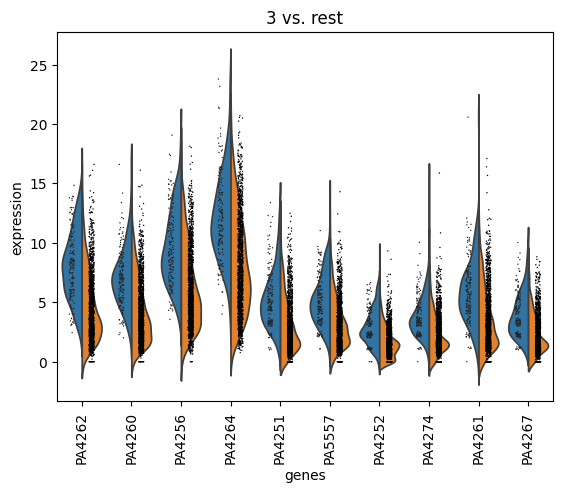

In [68]:
nclust = len(np.unique(data_counts.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(data_counts, groups=str(i), n_genes=10)